# LSTM Hyperparameter Tuning 
## Importing Libraries and Data

In [24]:
import pandas as pd
import numpy as np
from pandas import read_csv
import time
from pandas import datetime
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from prophet import Prophet 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch, Hyperband
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
df = read_csv('C:/Users/tomna/Desktop/Notebooks/Industrial Production of Electric and Gas Utilities/final_data.csv')
df.head()

,Observation_Date,Production_Index
0,01/01/1939,3.3335
1,01/02/1939,3.3590
2,01/03/1939,3.4353
3,01/04/1939,3.4607
4,01/05/1939,3.4607


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Observation_Date  1005 non-null   object 
 1   Production_Index  1005 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [26]:
# converting Time column to standard date/time format
df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%d/%m/%Y')  # m for month, M for min
df_prophet = df.copy()    # copy the dataframe for prediction analysis using prophet in the later sections
#display(df_prophet.head())   #  jupiter inbuilt function to print dataframe nicely
df = df.set_index('Observation_Date')
df = df.asfreq('MS', fill_value=np.nan)  # set the series frequency as month, starting at the first day of each month
df = df.sort_index()  # sort df by index in ascending order
df_DL = df.copy() # copy the dataframe for prediction analysis using deep learning approaches in the later sections
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [27]:
#verify that the series is complete, covering all time range
missing_times = pd.date_range(df.index.min(), df.index.max(), freq=df.index.freq).difference(df.index).to_list()
if len(missing_times) == 0:
    print('The series is complete!')
else:
    print('The series is INCOMPLETE!! The following times are missing: ', missing_times)
    
# if (df.index == pd.date_range(start=df.index.min(), end=df.index.max(), freq=df.index.freq)).all() :  # all() or any() can be used
#     print('The series is complete!')
# else:
#     missing_times = pd.date_range(df.index.min(), df.index.max(), freq=df.index.freq).difference(df.index).to_list()
#     print('The series is INCOMPLETE!! The following times are missing: ', missing_times)

The series is complete!


In [28]:
# check missing values for each column
df.isnull().sum()

Production_Index    0
dtype: int64

The prediction required is hourly demand of electricity but the current frequency is half an hour, so we convert the data to hourly frequency 

In [29]:
# cross checking the new frequency of the index if it is hourly
pd.infer_freq(df.index)

'MS'

## LSTM Tuning

In [30]:
# get the original dataframe with dates as index
df = df_DL
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [31]:
# converting the dataframe into a supervised series as per LSTM input shape format requirements
# first we define the function which converts df into a series of a historical data (X) defined by a window size (time steps) for predicting the next value (y) as per below example
    # [[[1], [2], [3], [4], [5]]] [6]
    # [[[2], [3], [4], [5], [6]]] [7]
    # [[[3], [4], [5], [6], [7]]] [8]
def create_supervised_series(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# set random seed
np.random.seed(7) # set the seed to ensure that our sample data in the train and test dataset will be the same every time we use the same seed number

In [32]:
#normalize the dataset
print('Shape before scaling: ', df.shape)
print('Min Max: ', df['Production_Index'].min(), ', ', df['Production_Index'].max())
df_as_np = df.values.astype('float32')  # ensure all values are in float, values returned as numpy array
scaler = MinMaxScaler(feature_range=(0, 1))
df_as_np = scaler.fit_transform(df_as_np)  # data is returned as numpy array
print('Shape after scaling: ', df_as_np.shape)
print('Min Max: ', df_as_np.min().round(5), ', ', df_as_np.max().round(5))

Shape before scaling:  (1005, 1)
Min Max:  3.3335 ,  126.5273
Shape after scaling:  (1005, 1)
Min Max:  0.0 ,  1.0


In [33]:
# splitting data into train and test datasets
train_size = int(len(df_as_np) * 0.8)  # assign 80% of data for training. The number should an integer to work in the next statement
df_train = df_as_np[0:train_size, :] # slicing numpy array - without iloc
df_test = df_as_np[train_size:len(df)+1, :]
print('Train & Test data size: ', len(df_train), ', ', len(df_test))
# reshape into X=t and y=t+1
look_back = 1
X_train, y_train = create_supervised_series(df_train, look_back)
X_test, y_test = create_supervised_series(df_test, look_back)
print('Train data shapes: ', X_train.shape, y_train.shape)
print('Test data shapes: ', X_test.shape, y_test.shape)

Train & Test data size:  804 ,  201
Train data shapes:  (802, 1) (802,)
Test data shapes:  (199, 1) (199,)


In [34]:
# reshape the input to be [samples, time steps, features]
# HERE we use a WINDOW based time series method. This approach uses previous lags (lookback) as unique input features processed at one time (timesteps=1)
timesteps = 1
X_train = np.reshape(X_train, (X_train.shape[0], timesteps, X_train.shape[1])) # features=look_back
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, X_test.shape[1]))
print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)

X_train and X_test new shapes:  (802, 1, 1) ,  (199, 1, 1)


In [35]:
# # reshape the input to be [samples, time steps, features]
# # HERE we use a TIME STEP based time series method. This approach uses previous lags as a series of one input feature processed at different time steps
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # timesteps=X_train.shape[1]
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)

In [36]:
def build_LSTM(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1',min_value=32,max_value=1024,step=32,default=128),
                activation=hp.Choice('dense_activation_1',values=['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'softmax', 'softplus', 'softsign']),
                kernel_initializer=hp.Choice('kernel_initializer_1',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
                input_shape=(timesteps, look_back),return_sequences=True)) # (samples, timesteps, features). It is not neccessary to assign samples regardless its size
    model.add(Dropout(rate=hp.Choice('dropout_1',values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(LSTM(units=hp.Int('units_2',min_value=32,max_value=1024,step=32,default=128),
                kernel_initializer=hp.Choice('kernel_initializer_2',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
                activation=hp.Choice('dense_activation_2',values=['relu', 'tanh', 'sigmoid']),
                return_sequences=True))
    model.add(Dropout(rate=hp.Choice('dropout_2',values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(LSTM(units=hp.Int('units_3',min_value=32,max_value=512,step=32,default=128),
                kernel_initializer=hp.Choice('kernel_initializer_3',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
                activation=hp.Choice('dense_activation_3',values=['relu', 'tanh', 'sigmoid']),
                return_sequences=False))
    model.add(Dropout(rate=hp.Choice('dropout_3',values=[0.1,0.2,0.3,0.4,0.5])))
#     model.add(LSTM(units=hp.Int('units_4',min_value=32,max_value=512,step=32,default=128),
#                 kernel_initializer=hp.Choice('kernel_initializer_4',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']),
#                 activation=hp.Choice('dense_activation_4',values=['relu', 'tanh', 'sigmoid']),
#                 return_sequences=False))
#     model.add(Dropout(rate=hp.Choice('dropout_4',values=[0.1,0.2,0.3,0.4,0.5])))
#     model.add(Dense(hp.Int('neurons',min_value=32,max_value=512,step=32,default=128),
#                 activation=hp.Choice('dense_activation_5',values=['relu', 'tanh', 'sigmoid']), 
#                 kernel_initializer=hp.Choice('kernel_initializer_5',values=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])))
#     model.add(Dropout(rate=hp.Choice('dropout_5',values=[0.1,0.2,0.3,0.4,0.5])))
    model.add(Dense(1, activation='linear'))  
    optimizer = Adam(hp.Choice('learning_rate',values=[0.001,0.01,0.1,0.2,0.3,0.4,0.5]))
    model.compile(loss='mean_squared_error', optimizer=optimizer) 
    return model

In [37]:
stop_early = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]  # set early stopping to prevent overfitting
tuner = Hyperband(build_LSTM, objective='val_loss', max_epochs=20, directory='Time Series Forecasting',
                  project_name='LSTM_Tuning', overwrite=True)
tuner.search(X_train, y_train, epochs=200, batch_size=30, validation_split=0.2, verbose=0, callbacks=stop_early)
tuner.results_summary()
best_params = tuner.get_best_hyperparameters()
print('Best Params: ',best_params[0].values)

INFO:tensorflow:Oracle triggered exit
Results summary
Results in Time Series Forecasting\LSTM_Tuning
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 992
dense_activation_1: linear
kernel_initializer_1: glorot_normal
dropout_1: 0.4
units_2: 992
kernel_initializer_2: normal
dense_activation_2: sigmoid
dropout_2: 0.2
units_3: 224
kernel_initializer_3: glorot_uniform
dense_activation_3: sigmoid
dropout_3: 0.3
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.003459540894255042
Trial summary
Hyperparameters:
units_1: 640
dense_activation_1: relu
kernel_initializer_1: uniform
dropout_1: 0.5
units_2: 416
kernel_initializer_2: he_normal
dense_activation_2: sigmoid
dropout_2: 0.2
units_3: 96
kernel_initializer_3: he_uniform
dense_activation_3: tanh
dropout_3: 0.5
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00347581272944808
Trial summary
Hyperparamete

In [38]:
# get the best epoch between 1 and the specificied one using epochs variable
best_model = tuner.get_best_models()[0]
history = best_model.fit(X_train, y_train, epochs=200, validation_split=0.1, verbose=0)
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1  
print('\n Best epoch: ', best_epoch)
# rebuild the best model with the best epoch and evaluate using the test data
best_model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.1, verbose=0)
best_model.summary()


 Best epoch:  10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 992)            3944192   
                                                                 
 dropout (Dropout)           (None, 1, 992)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 992)            7876480   
                                                                 
 dropout_1 (Dropout)         (None, 1, 992)            0         
                                                                 
 lstm_2 (LSTM)               (None, 224)               1090432   
                                                                 
 dropout_2 (Dropout)         (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)

In [39]:
# predicting train data
y_train_pred = best_model.predict(X_train, verbose=0)
# predicting test data
y_test_pred = best_model.predict(X_test, verbose=0)
# inverse actual data and predictions to their original scales
y_train = np.reshape(y_train, (y_train.shape[0], 1))  # changing the shape of the data to resamble with the predicted ones i.e from (1, y_train.shape[0]) to (y_train.shape[0], 1)
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
print()
print('X_train and X_test new shapes: ', X_train.shape, ', ', X_test.shape)
print('Train actuals and predictions shapes: ', y_train.shape, ', ', y_train_pred.shape)
print('Test actuals and predictions shapes: ', y_test.shape, ', ', y_test_pred.shape)


X_train and X_test new shapes:  (802, 1, 1) ,  (199, 1, 1)
Train actuals and predictions shapes:  (802, 1) ,  (802, 1)
Test actuals and predictions shapes:  (199, 1) ,  (199, 1)


In [40]:
# assessing model's performance in predicting train data
MAPE = round(mean_absolute_percentage_error(y_train, y_train_pred), 4)
MAE = round(mean_absolute_error(y_train, y_train_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  8.399999886751175 % |  MAE:  2.965  |  RMSE:  4.594


In [41]:
# converting the train actuals and predictions to dataframe. The values have no index, therefore index should be assigned (the requirement in DataFrame function) based on the index of the original series
    # we first convert the values from 2 dimensions to 1 dimensions (to remain with shape[0]) as required by dataframe function
y_train = y_train.flatten()
y_train_pred = y_train_pred.flatten()
df_train_results = pd.DataFrame({'Train Actuals':y_train, 'Train Predictions':y_train_pred}, index=df_DL.index[0:len(y_train)]) 

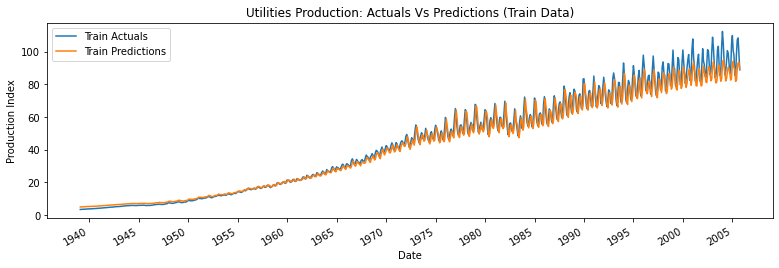

In [42]:
# plotting model's prediction on the train data
# we first shift the train data result to match its index with that of original data
df_train_results = df_train_results.shift(look_back)
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train_results['Train Actuals'], label='Train Actuals')  # reduce the period of training data for image clarity
ax.plot(df_train_results['Train Predictions'], label='Train Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
#ax.set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-09-01'))
#ax.set_ylim(bottom=80, top =140)
ax.set_title('Utilities Production: Actuals Vs Predictions (Train Data)')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
# auto format font and rotation for date tick labels
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()

In [43]:
# assessing model's performance in predicting test data
MAPE = round(mean_absolute_percentage_error(y_test, y_test_pred), 4)
MAE = round(mean_absolute_error(y_test, y_test_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  10.769999772310257 % |  MAE:  11.455  |  RMSE:  13.905


In [44]:
# converting the test actuals and predictions to dataframe
y_test = y_test.flatten()
y_test_pred = y_test_pred.flatten()
df_test_results = pd.DataFrame({'Test Actuals':y_test, 'Test Predictions':y_test_pred}, index=df_DL.index[len(y_train):len(y_train)+len(y_test)]) 

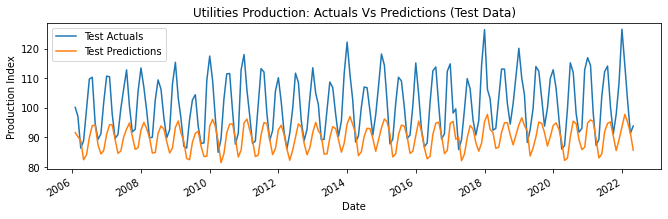

In [45]:
# plotting model's prediction on the test data
# we first shift the train data result to match its index with that of original data
df_test_results = df_test_results.shift(look_back*2 + 1)
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(df_test_results['Test Actuals'], label='Test Actuals')  # reduce the period of training data for image clarity
ax.plot(df_test_results['Test Predictions'], label='Test Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
#ax.set_xlim(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-09-01'))
#ax.set_ylim(bottom=80, top =140)
ax.set_title('Utilities Production: Actuals Vs Predictions (Test Data)')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
# auto format font and rotation for date tick labels
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()

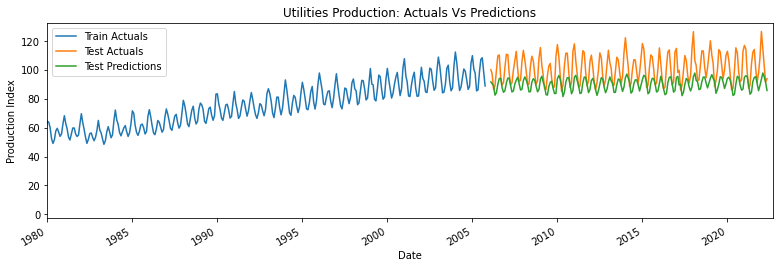

In [46]:
# plotting model's prediction on the test data
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train_results['Train Actuals'], label='Train Actuals')
ax.plot(df_test_results['Test Actuals'], label='Test Actuals')  # reduce the period of training data for image clarity
ax.plot(df_test_results['Test Predictions'], label='Test Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_xlim(pd.to_datetime('1980-01-01'), pd.to_datetime('2022-09-01'))
#ax.set_ylim(bottom=80, top =140)
ax.set_title('Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
# auto format font and rotation for date tick labels
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()